<a href="https://colab.research.google.com/github/dgomes03/assignments_ML/blob/main/Assignment4_Diogo_Gomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Normalize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0,1] and shape (C, H, W)
])

# Download and prepare datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)   # Output: (32, 26, 26)
        self.pool1 = nn.MaxPool2d(2)                  # Output: (32, 13, 13)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # Output: (64, 11, 11)
        self.pool2 = nn.MaxPool2d(2)                  # Output: (64, 5, 5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # raw logits, use CrossEntropyLoss

In [ ]:
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Epoch 1: Train Accuracy = 0.9397, Validation Accuracy = 0.9825
Epoch 2: Train Accuracy = 0.9811, Validation Accuracy = 0.9857
Epoch 3: Train Accuracy = 0.9870, Validation Accuracy = 0.9880
Epoch 4: Train Accuracy = 0.9898, Validation Accuracy = 0.9869


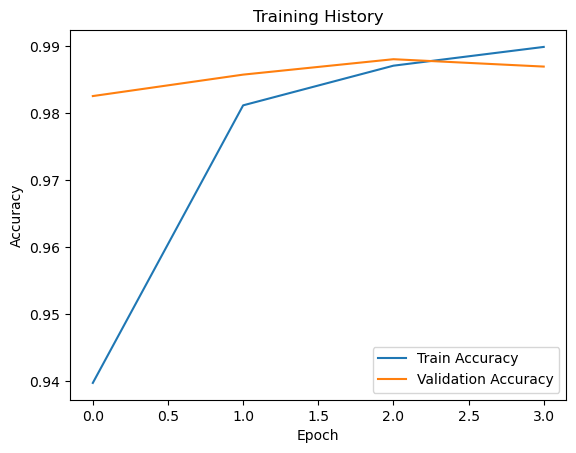

In [ ]:
epochs = 4
train_acc_history = []
val_acc_history = []

for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        preds = output.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)

    train_acc = correct / total
    train_acc_history.append(train_acc)

    # validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            preds = output.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)

    val_acc = correct / total
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}: Train Accuracy = {train_acc:.4f}, Validation Accuracy = {val_acc:.4f}")

plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

summary(model, input_size=(1, 28, 28), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
         MaxPool2d-2           [-1, 32, 13, 13]               0
            Conv2d-3           [-1, 64, 11, 11]          18,496
         MaxPool2d-4             [-1, 64, 5, 5]               0
           Flatten-5                 [-1, 1600]               0
            Linear-6                   [-1, 64]         102,464
            Linear-7                   [-1, 10]             650
Total params: 121,930
Trainable params: 121,930
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 0.47
Estimated Total Size (MB): 0.76
----------------------------------------------------------------


In [ ]:
# saving model
torch.save(model.state_dict(), "/Users/diogogomes/Documents/Uni/Machine Learning/Assignments/4/pytorch_model.bin")

In [ ]:
# load model

model = CNN()
model.load_state_dict(torch.load("pytorch_model.bin", map_location='cpu', weights_only=True))
model.eval()

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1600, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)